In [1]:
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import kagglehub
import torch
import os
%matplotlib inline

In [2]:
def download_dataset() -> str:
    path = kagglehub.dataset_download("rishitjakharia/names-txt")
    return path # for easier access later

In [95]:
dataset_path = download_dataset() + "/names.txt"

In [96]:
words = open(dataset_path, 'r').read().splitlines()

In [97]:
def make_int_char_maps() -> tuple[dict, dict]:
  chars = sorted(list(set(''.join(words))))
  ctoi = {c: i + 1 for i, c in enumerate(chars)}
  ctoi['.'] = 0
  itoc = {i: c for c, i in ctoi.items()}
  return ctoi, itoc

In [98]:
ctoi, itoc = make_int_char_maps()

In [7]:
print(itoc)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [8]:
print(ctoi)

{'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26, '.': 0}


In [146]:
def build_dataset(inp_words) -> tuple[torch.tensor, torch.tensor]:

  block_size = 3 # context length -> how many chars does it take to predict the next
  inp, target = [], []
  for w in inp_words:
    context = [0] * block_size

    for ch in w + '.':
      ix = ctoi[ch]
      inp.append(context)
      target.append(ix)
      context = context[1:] + [ix] # crop and append

  inp = torch.tensor(inp)
  target = torch.tensor(target)
  return inp, target

In [147]:
import random
random.seed(42)
random.shuffle(words)

n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xval, Yval = build_dataset(words[n1:n2])
Xtest, Ytest = build_dataset(words[n2:])

In [148]:
Xtr.shape, Xval.shape, Xtest.shape

(torch.Size([182625, 3]), torch.Size([22655, 3]), torch.Size([22866, 3]))

In [101]:
inp, target = build_dataset(words)

In [102]:
inp.shape, target.shape, inp.dtype, target.dtype

(torch.Size([228146, 3]), torch.Size([228146]), torch.int64, torch.int64)

In [103]:
C = torch.randn(27, 2) # 27 characters mapping to a 2d vector embedding`

In [104]:
C[5]

tensor([-2.2621, -1.0324])

In [105]:
(F.one_hot(torch.tensor(5), num_classes=27).float() @ C) # one hot allows us to pluck out a desired row
                                                         # however, notice its the same as indexing, so this wont be used

tensor([-2.2621, -1.0324])

inp contains contexts, defined in build dataset above
each context contains index mappings from ctoi.
these allow us to access embeddings in C.
we can index into C efficienty with the help of PyTorch

In [106]:
C[inp].shape

torch.Size([228146, 3, 2])

In [107]:
emb = C[inp]

In [108]:
W1 = torch.randn((6, 100)) # this is our hiddem layer, recieving 6 inputs, since each input has three characters, each having two elements
B1 = torch.randn(100) # 100 biases for each weight

In [109]:
h = torch.tanh(emb.view(-1, 6) @ W1 + B1)

In [110]:
h

tensor([[-0.1989,  0.9932,  0.8712,  ..., -0.3587,  0.9825,  0.0671],
        [-0.7556,  0.9890,  0.5291,  ..., -0.9993,  0.9179,  0.7073],
        [ 0.9972,  0.6793, -1.0000,  ..., -0.8393,  0.9959,  0.7883],
        ...,
        [ 0.8385, -0.7110, -0.9753,  ...,  0.9996, -0.8710, -0.9990],
        [-0.9909,  0.9841,  1.0000,  ..., -0.1176, -0.9332, -0.3188],
        [ 0.9999,  0.9999,  0.8939,  ..., -0.6507,  0.9907,  0.0214]])

In [114]:
W2 = torch.randn(100, 27)
B2 = torch.randn(27)

In [115]:
logits = h @ W2 + B2

In [116]:
counts = logits.exp()

In [117]:
probs = counts / counts.sum(1, keepdim=True)

In [120]:
probs[torch.arange(inp.shape[0]), target] # the probabilties for our target characters for each input

tensor([7.4721e-05, 2.1083e-10, 1.8727e-09,  ..., 2.4234e-05, 1.8780e-17,
        1.3458e-15])

In [122]:
loss = -probs[torch.arange(inp.shape[0]), target].log().mean()

In [123]:
loss.item()

14.291122436523438

Now altogether

In [124]:
W1 = torch.randn((6, 100))
B1 = torch.randn(100)
W2 = torch.randn(100, 27)
B2 = torch.randn(27)
params = [C, W1, B1, W2, B2]

In [125]:
sum(p.nelement() for p in params ) # number of parameters

3481

In [127]:
emb = C[inp]
h = torch.tanh(emb.view(-1, 6) @ W1 + B1)
logits = h @ W2 + B2
counts = logits.exp()
probs = counts / counts.sum(1, keepdim=True)
loss = -probs[torch.arange(inp.shape[0]), target].log().mean()

In [128]:
loss # this loss is different from above because we initialize new random weights and biases

tensor(15.9430)

F.cross_entropy on logits and target does this calculation, giving the same loss when we calculate counts to -prob[torch.arange(32), target].log().mean() is calculated, but much quicker

In [129]:
logit = torch.tensor([-5, 0, 3, 5]) + 6
count = logit.exp()
prob = count / count.sum()
prob

tensor([3.9751e-05, 5.8995e-03, 1.1849e-01, 8.7557e-01])

Any constant we add to logits will still result in the same prob ...
Let the logits be:
$$
\text{logit} = \begin{bmatrix} -5 \\ 0 \\ 3 \\ 5 \end{bmatrix} + 6 = \begin{bmatrix} 1 \\ 6 \\ 9 \\ 11 \end{bmatrix}
$$

Exponentiated values:
$$
\text{count} = \exp(\text{logit}) = \begin{bmatrix} e^1 \\ e^6 \\ e^9 \\ e^{11} \end{bmatrix}
$$

This Also Equals
$$
\exp(\text{logit}) = e^6 ⋅ \begin{bmatrix} e^{-5} \\ e^0 \\ e^3 \\ e^{5} \end{bmatrix}
$$

Normalized probabilities:
$$
\text{prob} = \frac{\text{count}}{\sum \text{count}} = \frac{e^6 \cdot \begin{bmatrix} e^{-5} \\ e^0 \\ e^3 \\ e^5 \end{bmatrix}}{e^6 \cdot (e^{-5} + e^0 + e^3 + e^5)}
$$

Further:
$$
\text{prob} = \frac{\text{count}}{\sum \text{count}} = \frac{\begin{bmatrix} e^{-5} \\ e^0 \\ e^3 \\ e^5 \end{bmatrix}}{e^{-5} + e^0 + e^3 + e^5} \text{, Which is simply the normalization of our original tensor}
$$

Adding a constant to our logits does not change the probability tensor, given we don't go out of bounds when calculating exp. Negative numbers will be useful here, since if we have a overflowing number already in our logits, then it can overflow in counts, but if we offset by -max(logits) then we can can ensure no overflow, previously I was doing this calculation manually, but this is actually handled by F.cross_entropy

In [119]:
# overflow example
logit = torch.tensor([-5, 0, 3, 100])
count = logit.exp()
prob = count / count.sum()
prob

tensor([0., 0., 0., nan])

In [120]:
# fixing overflow
logit = torch.tensor([-5, 0, 3, 100]) - logit.max()
count = logit.exp()
prob = count / count.sum()
prob

tensor([0.0000e+00, 3.7835e-44, 7.4689e-43, 1.0000e+00])

In [138]:
# further showing we can add any constant as long as we dont overflow
logit = torch.tensor([-5, 0, 3, 100]) - logit.max() + 1
count = logit.exp()
prob = count / count.sum()
prob

tensor([0.0000e+00, 3.7835e-44, 7.4689e-43, 1.0000e+00])

Continuing

In [149]:
Xtr.shape, Ytr.shape

(torch.Size([182625, 3]), torch.Size([182625]))

In [167]:
C = torch.randn(27, 10)
W1 = torch.randn((30, 200)) # network
B1 = torch.randn(200)
W2 = torch.randn(200, 27)
B2 = torch.randn(27)
params = [C, W1, B1, W2, B2]
for p in params:
  p.requires_grad = True

In [ ]:
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre
plt.plot(lrs)

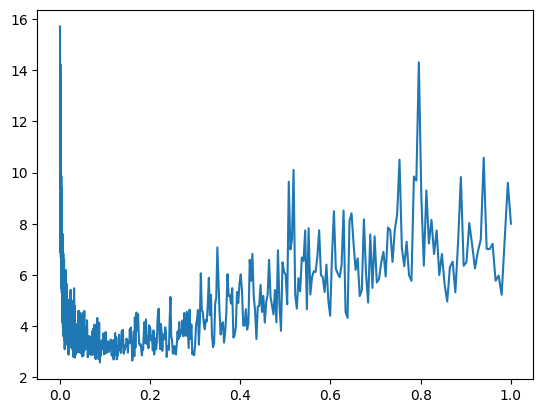

In [135]:
#plt.plot(lri, lossi)

In [168]:
lri = []
lossi = []
stepi = []


In [183]:
for i in range(20_000):

  # mini batches
  ix = torch.randint(0, Xtr.shape[0], (32,))

  # forward pass
  emb = C[Xtr][ix]
  h = torch.tanh(emb.view(-1, 30) @ W1 + B1)
  logits = h @ W2 + B2
  loss = F.cross_entropy(logits, Ytr[ix])

  # reset grads
  for p in params:
    p.grad = None

  # backward pass
  loss.backward()

  lr = 0.01
  for p in params:
    p.data += p.grad * -lr

  #lri.append(lre[i])
  lossi.append(loss.log10().item())
  stepi.append(i)

print(loss.item())

2.1291821002960205


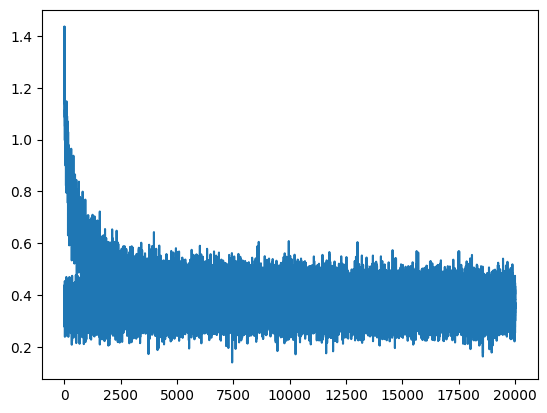

In [184]:
plt.plot(stepi, lossi)

In [185]:
# loss on dataset
emb = C[Xval]
h = torch.tanh(emb.view(-1, 30) @ W1 + B1)
logits = h @ W2 + B2
loss = F.cross_entropy(logits, Yval)
loss.item()

2.2647359371185303

In [186]:
emb = C[Xtr]
h = torch.tanh(emb.view(-1, 30) @ W1 + B1)
logits = h @ W2 + B2
loss = F.cross_entropy(logits, Ytr)
loss.item()

2.253598690032959

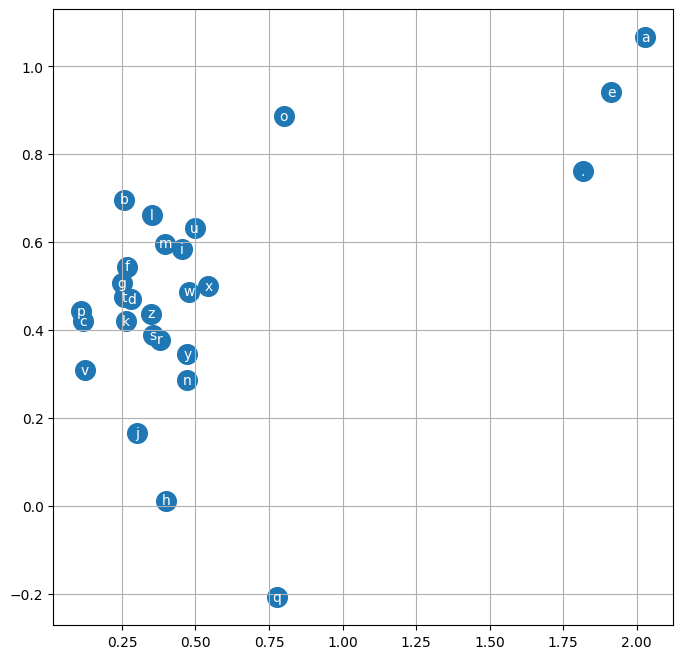

In [187]:
# embeddings
plt.figure(figsize=(8, 8))
plt.scatter(C[:, 0].data, C[:, 1].data, s=200)
for i in range(C.shape[0]):
  plt.text(C[i, 0].item(), C[i, 1].item(), itoc[i], ha='center', va='center', color='white')
plt.grid('minor')

In [281]:
# sampling from model

block_size = 3

for _ in range(20):

  out = []
  context = [0] * block_size

  while True:
    emb = C[torch.tensor([context])]
    h = torch.tanh(emb.view(1, -1) @ W1 + B1)
    logits = h @ W2 + B2
    probs = F.softmax(logits, dim=1)
    ix = torch.multinomial(probs, num_samples=1).item()
    context = context[1:] + [ix]
    out.append(ix)
    if ix == 0:
      break

  print(''.join(itoc[i] for i in out))

nishamian.
jake.
aivik.
dayde.
renanah.
kalylen.
shanamiakhanka.
elemilly.
kya.
perlyn.
lavi.
zimeen.
izy.
niah.
tulq.
rhaan.
ruzath.
syle.
chentecikton.
pon.
